In [ ]:
# develop-activating-states-function.ipynb
#
# Bryan Daniels
# 2024/1/8
#
# As part of an effort to find all basins of size 1, we need a function that takes a 
# Neet network and a node index and produces the states that activate or deactivate 
# that node.
#

For `LogicNetwork`s, this is easy, because we already store the network's logic table in a similar format.

For `WTNetwork`s, we will just want to analyze all possible states of each node's inputs.

In [1]:
from neet import UniformSpace

def activating_states(net,node_index,activate=True):
    """
    Returns the states that activate or deactivate a given node in a Neet network.
    
    Returns: (neighbors_tuple,conditions),
    where neighbors_tuple is a sorted tuple of node indices on which the given node depends, 
    and conditions is a tuple of binary states that activate the given node
    (or deactivate the given node if activate=False)
    """
    neighbors_list = tuple(sorted(net.neighbors_in(node_index)))
    conditions = []
    default_state = [ 0 for i in range(net.size) ] # states to which other non-input nodes are set
    input_space = UniformSpace(len(neighbors_list),2) # create binary input space
    for reduced_state in input_space:
        
        # set starting state to have given values for input nodes
        full_state = default_state.copy()
        for i,neighbor in enumerate(neighbors_list):
            full_state[neighbor] = reduced_state[i]
        
        # check whether this state is activating for node_index
        if net.update(full_state)[node_index] == activate:
            conditions.append(tuple(reduced_state))
            
    return neighbors_list,tuple(conditions)

### checks

In [2]:
# load/create some example networks
from neet.boolean.examples import mouse_cortical_7B # a logic network
from neet.boolean.examples import c_elegans # a weight-threshold network
from neet.boolean.examples import hgf_signaling_in_keratinocytes # a larger logic network
from neet.boolean import LogicNetwork
test_table = [((1,0),{'10','11'}),
              ((1,),{'1'})]
test_net = LogicNetwork(test_table)

In [3]:
import numpy as np

# check that the sum of activating and deactivating states is 2^(number of inputs)
def check_sum(net):
    for i in range(net.size):
        neighbors,act_conditions = activating_states(net,i,True)
        neighbors,deact_conditions = activating_states(net,i,False)
        assert(len(act_conditions) + len(deact_conditions) == 2**(len(neighbors)))
        
# check that a logic table network has the same inputs and activating conditions
def check_logic(net):
    for i in range(net.size):
        neighbors,act_conditions = activating_states(net,i)
        
        # check that neighbors are the same
        assert(tuple(sorted(net.table[i][0])) == neighbors)
        
        # check that length of activating conditions is the same
        assert(len(net.table[i][1]) == len(act_conditions))
        
        # check that activating conditions are the same
        if len(neighbors) > 0:
            table_conditions = [ np.array([int(val) for val in list(condition)]) for condition in net.table[i][1] ]
            sorted_table_conditions = [ tuple(condition[np.argsort(net.table[i][0])]) \
                                             for condition in table_conditions ]
            assert(set(sorted_table_conditions) == set(act_conditions))

In [4]:
check_sum(c_elegans)
check_sum(mouse_cortical_7B)
check_sum(hgf_signaling_in_keratinocytes)
check_sum(test_net)

In [5]:
check_logic(mouse_cortical_7B)
check_logic(hgf_signaling_in_keratinocytes)
check_logic(test_net)

In [6]:
mouse_cortical_7B.table

[((9,), {'1'}),
 ((5, 7), {'00'}),
 ((5, 8), {'10'}),
 ((5, 7, 9), {'000'}),
 ((8, 6), {'00'}),
 ((0,), {'1'}),
 ((1,), {'1'}),
 ((2,), {'1'}),
 ((3,), {'1'}),
 ((4,), {'1'})]

In [7]:
activating_states(mouse_cortical_7B,1,True)

((5, 7), ((0, 0),))

In [8]:
activating_states(hgf_signaling_in_keratinocytes,0)

((33, 40, 43),
 ((1, 0, 0), (0, 1, 0), (1, 1, 0), (0, 0, 1), (1, 0, 1), (0, 1, 1), (1, 1, 1)))

In [9]:
activating_states(test_net,0)

((0, 1), ((0, 1), (1, 1)))

# 2024/1/8

In [5]:
# from https://github.com/EnricoBorriello/Boolean-Backwards-Reachability/blob/main/backreach.py
def conditions_product(df1,df2):
	'''
	Activating conditions for functions 1 AND 2 given the input truth tables 
	for function 1 and function 2. The inputs need to be dataframes with column names 
	corresponding to the the labes of the nodes.
	'''

	# Firts check if the two function share input nodes

	shared_columns = list(set(df1.columns) & set(df2.columns))

	if len(shared_columns) == 0:
		#if they don't, take all possible products of conditions
		merged_df = pd.merge(df1, df2, how = 'cross')
	else:
		#if they do, just keep the non conflicting ones
		merged_df = pd.merge(df1, df2, on = shared_columns)

	merged_df = merged_df.sort_index(axis=1)

	return merged_df

In [8]:
import pandas as pd
import numpy as np
import networkx as nx
from neet.boolean.examples import c_elegans
from neet.boolean import WTNetwork
#from neet.controlkernel import modularity as md

In [7]:
decoded_attractors = [ [ c_elegans.decode(state) for state in att ] \
                         for att in c_elegans.attractors ]

TO DO: RUN THE FOLLOWING FUNCTION FOR ALL NETWORKS AND TEST FOR ATTRACTORS WITH PREIMAGE OF LENGTH 1

In [12]:
def activating_conditions_df(net,node_index,node_state):
    nodes,conditions = activating_states(net,node_index,activate=node_state)
    return pd.DataFrame(conditions,columns=nodes)

def preimages(net,state,communities=None):
    """
    Given a state of a Neet network, returns a list of all primages of that state
    (all states that produce the given state after one timestep)
    """
    if communities == None:
        communities = [range(net.size)]
    
    df_list = []
    for community in communities:
        community = list(community)
        df = activating_conditions_df(net,community[0],state[community[0]])
        for i in range(1,len(community)):
            dfi = activating_conditions_df(net,community[i],state[community[i]])
            df = conditions_product(df,dfi)
        df_list.append(df)
    #return df_list
    return conditions_product_list(df_list)

In [127]:
nx_net = hgf_signaling_in_keratinocytes.network_graph()
communities = nx.community.louvain_communities(nx_net.to_undirected())

In [128]:
communities

[{8, 9, 23, 27, 34, 44, 57},
 {13, 15, 21, 25, 29, 41, 51, 64, 65},
 {5, 12, 14, 18, 28, 48, 49, 53},
 {10, 11, 16, 22, 31, 35, 37, 39, 56},
 {2, 19, 30, 32, 52, 58, 66},
 {0, 1, 4, 33, 38, 40, 45, 50, 55, 60},
 {6, 7, 43, 61, 62},
 {3, 17, 20, 24, 26, 36, 42, 46, 47, 54, 59, 63, 67}]

In [129]:
df_list = preimages(hgf_signaling_in_keratinocytes,np.zeros(hgf_signaling_in_keratinocytes.size),communities)

In [7]:
def conditions_product_list(df_list):
    """
    Return the product of a list of condition dataframes.
    """
    df = df_list[0]
    for dfi in df_list[1:]:
        df = conditions_product(df,dfi)
    return df

In [ ]:
# test on biased weight-threshold network where we can compute basin sizes exactly

In [10]:
N = 5
net_test = WTNetwork(np.ones([N,N]))

In [13]:
net_test.attractors

array([[ 0],
       [31]])

In [14]:
net_test.basin_sizes

array([ 1, 31])

In [17]:
preimages(net_test,np.zeros(N))

,0,1,2,3,4
0,0,0,0,0,0


In [77]:
# try on a cell collective network that we care about

In [78]:
from neet.boolean import LogicNetwork
def load_cell_collective_network(directory):
    """
    Creates neet network from cell collective data in the
    given directory.
    """
    expressions_file = '{}/expressions.txt'.format(directory)
    external_file = '{}/external.txt'.format(directory)
    net = LogicNetwork.read_logic(expressions_file, external_file)
    return net

In [131]:
CELL_COLLECTIVE_DIR = '/Users/bdaniel6/ASUDropbox/Research/control-continuous/Data/Cell Collective/'
selected_name = 'SKBR3_Breast_Cell_Line_Long-term_ErbB_Network'
net = load_cell_collective_network(CELL_COLLECTIVE_DIR+selected_name)

In [132]:
atts = md.attractors(net)

KeyboardInterrupt: 

In [133]:
decoded_atts = [ [ net.decode(state) for state in att ] \
                         for att in atts ]

In [134]:
decoded_atts[1]

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [135]:
communities = nx.community.louvain_communities(net.network_graph().to_undirected())

In [138]:
df_list = preimages(net,decoded_atts[8][0],communities)

In [139]:
conditions_product_list(df_list)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
import tqdm

In [140]:
lengths = []
for a in tqdm.tqdm(decoded_atts):
    df_list = preimages(net,a[0],communities)
    lengths.append(len(conditions_product_list(df_list)))

100%|███████████████████████████████████████| 3185/3185 [01:51<00:00, 28.62it/s]


In [122]:
decoded_atts[8]

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [123]:
net.update(decoded_atts[8][0])

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [125]:
net.size

25

In [124]:
communities

[{1, 4, 19, 22},
 {0, 2, 5, 9, 15, 24},
 {3, 16, 21, 23},
 {6, 7, 11, 13, 20},
 {8, 12, 18},
 {10, 14, 17}]

In [112]:
import matplotlib.pyplot as plt

In [141]:
lengths

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 54,
 54,
 294,
 54,
 54,
 54,
 774,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 32,
 96,
 176,
 528,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 64,
 192,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 32,
 96,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 496,
 496,
 3920,
 496,
 270,
 270,
 270,
 270,
 270,
 270,
 270,
 270,
 992,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 16,
 16,
 16,
 16,
 1212,
 1212,
 1212,
 1212,
 32,
 32,
 32,
 32,
 16,
 16,
 16,
 16,
 116,
 116,
 1300,
 116,
 164,
 164,
 164,
 164,
 1184,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 48,
 48,
 272,
 48,
 224,
 1248,
 392,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


(array([3064.,   20.,   51.,   20.,    0.,    0.,   24.,    0.,    0.,
           6.]),
 array([1.00000e+00, 2.61930e+03, 5.23760e+03, 7.85590e+03, 1.04742e+04,
        1.30925e+04, 1.57108e+04, 1.83291e+04, 2.09474e+04, 2.35657e+04,
        2.61840e+04]),
 <BarContainer object of 10 artists>)

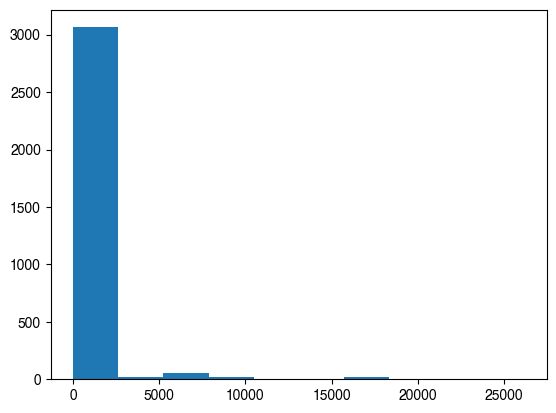

In [142]:
plt.hist(lengths)

In [147]:
np.sum(np.array(lengths)==1)

960

In [145]:
len(atts)

3185